In [11]:
# !curl -o zen_dataset.tar.gz https://www.dropbox.com/s/5ugsinj434yzmu6/zen_dataset.tar.gz?dl=0
!tar -xzvf zen_dataset.tar

x zen_dataset/
x zen_dataset/user_ratings.gz
x zen_dataset/.ipynb_checkpoints/
x zen_dataset/item_counts.csv
x zen_dataset/item_meta.gz


In [ ]:
!pip install catboost

# Ranking model

Classical multistage recommendations pipeline looks like following:

![](
https://raw.githubusercontent.com/girafe-ai/recsys/3f374f49cede21d25c777aa3a274b9cbadc29d19/homeworks/recsys-pipeline.png)

1. Candidate selection: on this stage we use relative simple models (embeddings kNN, collaborative filtering result or SLIM)
1. Ranking model: candidates collected on previous stage are evaluated with more complex model (usually boosting nowadays).
1. Reranking: applying business logic, heuristics and ad-hocs.

We discussed this pipeline on the first lecture.

In this task you are to build dataset and train ranking model using Dzen dataset.

You need to use gradient boosting model e.g. Catboost (however any other goes well). As features you will need:
* Dot product, cosine distance between user and item embeddings. Models to use as embeddings source are:  *explicit* and *implicit ALS*, content models
* Item and user statistics (counters) such as CTR, view count, etc.


In [1]:
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp

from tqdm.notebook import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

sns.set()

In [79]:
item_counts = pd.read_csv('zen_dataset/item_counts.csv', index_col=0)
item_meta = pd.read_csv('zen_dataset/item_meta.gz', compression='gzip', index_col=0)
user_ratings = pd.read_csv('zen_dataset/user_ratings.gz', compression='gzip', index_col=0)

In [81]:
item_counts

,count,itemId
0,-32849,2260449285691840072
1,-29208,-8961093042137696748
2,-27026,-767028345530903101
3,-26678,4123700977569815347
4,-23399,992305795279709612
...,...,...
104498,-50,-3176494955767409165
104499,-50,-5478208532961513420
104500,-50,6687694357626412438
104501,-50,-2783894177406771192


In [21]:
item_meta

,itemId,title,content
0,5480844460835530524,"Нехитрые способы, как самостоятельно проверить...","С раннего детства нам рассказывают, что сама..."
1,25708764690236829,Где находилась сверхсекретная база подводных л...,"Сомневаюсь, что найдётся сейчас человек, котор..."
2,25995859650472943,Тапки ( жуткий рассказ),Год назад эту историю рассказала мне моя родс...
3,26039067597386753,Крутые находки на Aliexpress №1113,"Доброго времени суток, Уважаемые читатели! Доб..."
4,26225874317634871,Нам пообещали высокую инфляцию. Деньги сильно ...,Цены в магазинах и темпы инфляции растут не то...
...,...,...,...
104498,6221825086402198588,Сколько можно заработать на видеокартах с AGP ...,"Очень старые видеокарты с интерфейсом AGP, кот..."
104499,6221897338759013055,Укрытие Роз на зиму,По Вашим просьбам - повторяю пост прошлого год...
104500,6221960724554910431,"Мама, мамочка, мамуля: снимки самого близкого ...",В подборке снимков из нашего архива — фотограф...
104501,6222047264920702976,Что лучше: сдавать наследственную квартиру или...,"""Кварта − новый бренд ПИК-Брокер"" Привет, меня..."


In [73]:
user_ratings

,userId,trainRatings,testRatings
0,-993675863667353526,"{'-5222866277752422391': 0, '-9060464686933784...","{'-2554466548053893601': 0, '-2220576615613681..."
1,-4250619547882954185,"{'-4553947455665416667': 0, '-3876917199970727...","{'-3523829386334236920': 0, '-1723368694207177..."
2,-3847785305345691076,"{'1455441194337562599': 0, '-17536433251064509...","{'1148168316930968740': 0, '706941777097091385..."
3,1785181112918558233,"{'-2853304815794005643': 0, '-8508657381620121...","{'4719491585277936855': 1, '706941777097091385..."
4,-5078748097863903181,"{'-742528302744844176': 1, '-82389094081541106...","{'6294770073358764390': 0, '-40435255593741244..."
...,...,...,...
75905,4954138831959898373,"{'-6764562552262937310': 0, '-7209088773475894...","{'-1685266709911581206': 0, '-5318736529174157..."
75906,4967793435819938014,"{'6602646631687202064': 0, '-38704649420060130...","{'6266145763213971476': 0, '-37217722565891246..."
75907,-7137764184903122777,"{'-7841343107825813783': 0, '-6743959661482653...","{'482864988385991583': 1, '-132806041087172535..."
75908,-2624987805086334956,"{'-8048759438586949657': 0, '-7609637705975070...","{'-5614425467424704155': 0, '62661457632139714..."


In [51]:
item_counts['itemId'] = item_counts['itemId'].apply(str)
item_meta['itemId'] = item_meta['itemId'].apply(str)

In [52]:
def parse_ratings_history(string):
    return json.loads(string.replace("'", '"'))

In [53]:
user_encoder = LabelEncoder().fit(user_ratings['userId'])
item_encoder = LabelEncoder().fit(item_counts['itemId'])

all_items = item_counts['itemId']
indices = item_encoder.transform(all_items)
item_to_id = dict(zip(all_items, indices))

In [77]:
user_ratings

,userId,trainRatings,testRatings
0,-993675863667353526,"{'-5222866277752422391': 0, '-9060464686933784...","{'-2554466548053893601': 0, '-2220576615613681..."
1,-4250619547882954185,"{'-4553947455665416667': 0, '-3876917199970727...","{'-3523829386334236920': 0, '-1723368694207177..."
2,-3847785305345691076,"{'1455441194337562599': 0, '-17536433251064509...","{'1148168316930968740': 0, '706941777097091385..."
3,1785181112918558233,"{'-2853304815794005643': 0, '-8508657381620121...","{'4719491585277936855': 1, '706941777097091385..."
4,-5078748097863903181,"{'-742528302744844176': 1, '-82389094081541106...","{'6294770073358764390': 0, '-40435255593741244..."
...,...,...,...
75905,4954138831959898373,"{'-6764562552262937310': 0, '-7209088773475894...","{'-1685266709911581206': 0, '-5318736529174157..."
75906,4967793435819938014,"{'6602646631687202064': 0, '-38704649420060130...","{'6266145763213971476': 0, '-37217722565891246..."
75907,-7137764184903122777,"{'-7841343107825813783': 0, '-6743959661482653...","{'482864988385991583': 1, '-132806041087172535..."
75908,-2624987805086334956,"{'-8048759438586949657': 0, '-7609637705975070...","{'-5614425467424704155': 0, '62661457632139714..."


In [42]:
item_counts

,count,itemId
0,32849,2260449285691840072
1,29208,-8961093042137696748
2,27026,-767028345530903101
3,26678,4123700977569815347
4,23399,992305795279709612
...,...,...
104498,50,-3176494955767409165
104499,50,-5478208532961513420
104500,50,6687694357626412438
104501,50,-2783894177406771192


In [32]:
all_items

0          2260449285691840072
1         -8961093042137696748
2          -767028345530903101
3          4123700977569815347
4           992305795279709612
                  ...         
104498    -3176494955767409165
104499    -5478208532961513420
104500     6687694357626412438
104501    -2783894177406771192
104502     4589467716844022952
Name: itemId, Length: 104503, dtype: object

In [80]:
user_ratings.trainRatings = user_ratings.trainRatings.map(eval)
user_ratings.testRatings = user_ratings.testRatings.map(eval)

In [81]:
total_interactions_count = user_ratings.trainRatings.map(len).sum()
user_coo = [0] * total_interactions_count
item_coo = [0] * total_interactions_count
pos = 0

for _, row in tqdm(user_ratings.iterrows()):
    item_ids = list(row.trainRatings.keys())
    user_id = row.userId
    for item in item_ids:
        user_coo[pos] = user_id
        item_coo[pos] = item
        pos += 1

user_coo = np.array(user_encoder.transform(user_coo), dtype=np.int64)
item_coo = np.array(item_encoder.transform(item_coo), dtype=np.int64)

shape = (max(user_coo) + 1, max(item_coo) + 1)
implicit_user_item_matrix = sp.coo_matrix(
    (np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape
)
implicit_user_item_matrix = implicit_user_item_matrix.tocsr()

0it [00:00, ?it/s]

In [8]:
total_interactions_count = user_ratings.testRatings.map(len).sum()
user_coo = [0] * total_interactions_count
item_coo = [0] * total_interactions_count
pos = 0

for _, row in tqdm(user_ratings.iterrows()):
    item_ids = list(row.testRatings.keys())
    user_id = row.userId
    for item in item_ids:
        user_coo[pos] = user_id
        item_coo[pos] = item
        pos += 1

user_coo = np.array(user_encoder.transform(user_coo), dtype=np.int64)
item_coo = np.array(item_encoder.transform(item_coo), dtype=np.int64)

shape = (max(user_coo) + 1, max(item_coo) + 1)
test_implicit_user_item_matrix = sp.coo_matrix(
    (np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape
)
test_implicit_user_item_matrix = test_implicit_user_item_matrix.tocsr()

0it [00:00, ?it/s]

In [26]:
implicit_user_item_matrix

<75910x104503 sparse matrix of type '<class 'numpy.float64'>'
	with 42185503 stored elements in Compressed Sparse Row format>

In [34]:
test_implicit_user_item_matrix

<75910x104503 sparse matrix of type '<class 'numpy.float64'>'
	with 9324073 stored elements in Compressed Sparse Row format>

In [65]:
total_interactions_count = user_ratings.trainRatings.map(lambda x: x.values()).map(sum).sum()
user_coo = [0] * total_interactions_count
item_coo = [0] * total_interactions_count
pos = 0

for _, row in tqdm(user_ratings.iterrows()):
    item_ids = [k for k, v in row.trainRatings.items() if v == 1]
    user_id = row.userId
    for item in item_ids:
        user_coo[pos] = user_id
        item_coo[pos] = item
        pos += 1

user_coo = np.array(user_encoder.transform(user_coo), dtype=np.int64)
item_coo = np.array(item_encoder.transform(item_coo), dtype=np.int64)

shape = (max(user_coo) + 1, max(item_coo) + 1)
explicit_user_item_matrix = sp.coo_matrix(
    (np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape
)
explicit_user_item_matrix = explicit_user_item_matrix.tocsr()

0it [00:00, ?it/s]

In [33]:
total_interactions_count = user_ratings.testRatings.map(lambda x: x.values()).map(sum).sum()
user_coo = [0] * total_interactions_count
item_coo = [0] * total_interactions_count
pos = 0

for _, row in tqdm(user_ratings.iterrows()):
    item_ids = [k for k, v in row.testRatings.items() if v == 1]
    user_id = row.userId
    for item in item_ids:
        user_coo[pos] = user_id
        item_coo[pos] = item
        pos += 1

user_coo = np.array(user_encoder.transform(user_coo), dtype=np.int64)
item_coo = np.array(item_encoder.transform(item_coo), dtype=np.int64)

shape = (max(user_coo) + 1, max(item_coo) + 1)
test_explicit_user_item_matrix = sp.coo_matrix(
    (np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape
)
test_explicit_user_item_matrix = test_explicit_user_item_matrix.tocsr()

0it [00:00, ?it/s]

In [35]:
test_explicit_user_item_matrix

<75910x104503 sparse matrix of type '<class 'numpy.float64'>'
	with 1157843 stored elements in Compressed Sparse Row format>

In [11]:
np.save('explicit_user_item_matrix', explicit_user_item_matrix)
np.save('implicit_user_item_matrix', implicit_user_item_matrix)

## ALS (10 points)

Train explicit и implicit ALS.

You may use your implementation from previous HW as well as library implementation such as _implicit_

In [8]:
import implicit

In [75]:
DIMENSION = 150 # choose appropriately

In [76]:
def calc_oposite_vectors_als(Y, A, k, lam):
    B = Y.T @ Y + lam * np.eye(k)
    C = A @ Y
    return (np.linalg.inv(B) @ C.T).T


def train_eals(data, dimension=DIMENSION, steps=10, lam: float=0.1):
    X, Y = np.random.rand(data.shape[0], dimension) * 0.01, np.random.rand(data.shape[1], dimension) * 0.01
    data = data.tocsr()
    for _ in tqdm(range(steps)):
        X = calc_oposite_vectors_als(Y, data, dimension, lam)
        Y = calc_oposite_vectors_als(X, data.T, dimension, lam)
    return X, Y


def train_ials(data, dimension=DIMENSION, steps=10, alpha=10):
    model = implicit.als.AlternatingLeastSquares(factors=dimension, iterations=steps, alpha=alpha)
    model.fit(data)
    return model.user_factors, model.item_factors


In [66]:
eals_user_embeddings, eals_item_embeddings = train_eals(implicit_user_item_matrix, dimension=DIMENSION)

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
np.save('implicit_eals_user_embeddings', eals_user_embeddings)
np.save('implicit_eals_item_embeddings', eals_item_embeddings)

In [17]:
ials_user_embeddings, ials_item_embeddings = train_ials(implicit_user_item_matrix, dimension=DIMENSION)

/opt/anaconda3/envs/recsys/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
np.save('implicit_ials_user_embeddings', ials_user_embeddings)
np.save('implicit_ials_item_embeddings', ials_item_embeddings)

In [20]:
def get_predictions(X, Y, train_ratings, user):
    preds = X[user, :] @ Y.T
    user_train = train_ratings[user, :].toarray().flatten()
    preds[user_train != 0] = -1
    return preds


def mrr(X, Y, train_ratings, test_ratings):
    mrr = 0
    users = np.unique(test_ratings.tocoo().row)
    for user in tqdm(users):
        user_preds = get_predictions(X, Y, train_ratings, user)
        top_idxs = np.argsort(-user_preds)[:100]
        user_test = test_ratings[user].toarray().flatten()
        test_idx, *_ = np.arange(user_test.size)[user_test == 1]
        if test_idx in top_idxs:
            mrr += 1/(np.where(top_idxs == test_idx)[0][0] + 1)
    mrr = mrr / users.size
    return mrr

In [67]:
eals_user_embeddings, eals_item_embeddings = train_eals(explicit_user_item_matrix, dimension=DIMENSION)

  0%|          | 0/10 [00:00<?, ?it/s]

In [68]:
ials_user_embeddings, ials_item_embeddings = train_ials(explicit_user_item_matrix, dimension=DIMENSION)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# imp_eals_user_embeddings, imp_eals_item_embeddings = train_eals(implicit_user_item_matrix, dimension=DIMENSION)

In [ ]:
# imp_ials_user_embeddings, imp_ials_item_embeddings = train_ials(implicit_user_item_matrix, dimension=DIMENSION)

In [21]:
mrr(ials_user_embeddings, ials_item_embeddings, explicit_user_item_matrix, test_explicit_user_item_matrix)

  0%|          | 0/75910 [00:00<?, ?it/s]

0.007536424708539673

In [22]:
mrr(eals_user_embeddings, eals_item_embeddings, explicit_user_item_matrix, test_explicit_user_item_matrix)

  0%|          | 0/75910 [00:00<?, ?it/s]

0.0067464772721947

In [23]:
#IMPLICIT FEEDBACK

#ALS_100 = 0.006345146202597134
#iALS_100 = 0.007157746940597567

#ALS_200 = 0.00708896555184268
#iALS_200 = unknown

#ALS_150 = 0.0067464772721947
#iALS_150 = 0.007536424708539673

In [39]:
# mrr(imp_eals_user_embeddings, imp_eals_item_embeddings, implicit_user_item_matrix, test_implicit_user_item_matrix)

  0%|          | 0/75470 [00:00<?, ?it/s]

0.0063751415340898634

In [40]:
# mrr(imp_ials_user_embeddings, imp_ials_item_embeddings, implicit_user_item_matrix, test_implicit_user_item_matrix)

  0%|          | 0/75470 [00:00<?, ?it/s]

0.007776806015417872

In [ ]:
#EXPLICIT FEEDBACK

#ALS_150 = 0.0063751415340898634
#iALS_150 = 0.007776806015417872

In [73]:
eals_user_embeddings = np.load('implicit_eals_user_embeddings.npy')
ials_user_embeddings = np.load('implicit_ials_user_embeddings.npy')
eals_item_embeddings = np.load('implicit_eals_item_embeddings.npy')
ials_item_embeddings = np.load('implicit_ials_item_embeddings.npy')

## Content model (5 points)

Choose content model you like and apply it to all the items (remember to use all available information).

Some sane choices are: RuBERT or any CLIP model. You may found them on [Hugging face](https://huggingface.co/models)

Which dimensionality to choose for content model? Why?

#### The more dimensionality the better, because we can encode more information into one embedding and therefore distinguish text better, but it may be computationaly expensive to calculate big embeddings. So for my working machine I decided to choose tiny model with 312 dimensional embeddings for better performance

In [9]:
import torch
from transformers import AutoTokenizer, AutoModel

In [10]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny')
model = AutoModel.from_pretrained('cointegrated/rubert-tiny')

In [11]:
def embed_bert_cls(text_batch, model, tokenizer):
    t = tokenizer(text_batch, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.pooler_output
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings.numpy()

In [13]:
union_item_meta = item_meta.copy().fillna('')
union_item_meta.content = (union_item_meta.title + union_item_meta.content)
union_item_meta = union_item_meta.drop(columns=['title'])
contents = union_item_meta.content.to_list()

In [28]:
content_item_embeddings = []

batch_size = 96
for i in tqdm(range(len(contents) // batch_size + 1)):
    batch = contents[i * batch_size: i * batch_size + batch_size]
    content_item_embeddings.extend(embed_bert_cls(batch, model, tokenizer))
content_item_embeddings = np.array(content_item_embeddings)

idxs = item_encoder.transform(item_meta.itemId.to_list())
content_item_embeddings = content_item_embeddings[idxs]
np.save('content_item_embeddings', content_item_embeddings)

In [74]:
content_item_embeddings = np.load('content_item_embeddings.npy')

In [149]:
content_item_embeddings

array([[ 0.06771927,  0.04696041,  0.02479797, ..., -0.04321409,
        -0.07780576, -0.0434058 ],
       [ 0.06798383,  0.02379908,  0.00141089, ..., -0.06548173,
        -0.05300865, -0.06558411],
       [ 0.03709507,  0.05597023, -0.00105805, ..., -0.09333857,
        -0.06550438, -0.06156313],
       ...,
       [ 0.09707466,  0.09181215,  0.01944108, ..., -0.00423168,
        -0.01650536, -0.04480753],
       [ 0.12560031,  0.07533925, -0.00904334, ..., -0.0732348 ,
         0.01089354, -0.04671086],
       [ 0.10808624,  0.02281853, -0.01055417, ..., -0.06082226,
         0.03319905, -0.03142886]], dtype=float32)

## ALS step from content model (5 points)

To use content based information (important for cold items and users) in user-item ranking you need to build user embeddings. One simple way is to perform ALS step with item embeddings fixed to compute user embeddings.

Then you will use these embeddings to compute user-item features for final ranking.

In [82]:
_, dimension = content_item_embeddings.shape
lam = 0.1
content_user_embeddings = calc_oposite_vectors_als(content_item_embeddings, implicit_user_item_matrix, dimension, lam)

## Ranking (10 points)


Build embedding based user-item features for ranking model.

In [71]:
class EmbeddingFeatureGetter:
    def __init__(self, user_embeddings, item_embeddings):
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings

    def get_features(self, user_id, item_ids):
        """
        * user_id -- user index to compute features
        * item_ids -- list of item indexes
        """
        u, i_s = self.user_embeddings[user_id], self.item_embeddings[item_ids]
        
        dot = u @ i_s.T
        cos = dot / (np.linalg.norm(u) * np.linalg.norm(i_s, axis=1))
        return dot, cos

In [83]:
eals_features_getter = EmbeddingFeatureGetter(eals_user_embeddings, eals_item_embeddings)
ials_features_getter = EmbeddingFeatureGetter(ials_user_embeddings, ials_item_embeddings)
content_features_getter = EmbeddingFeatureGetter(content_user_embeddings, content_item_embeddings)

Build item and user features:

In [59]:
user_ratings

,userId,trainRatings,testRatings,userId_encoded
0,-993675863667353526,"{'-5222866277752422391': 0, '-9060464686933784...","{'-2554466548053893601': 0, '-2220576615613681...",33745
1,-4250619547882954185,"{'-4553947455665416667': 0, '-3876917199970727...","{'-3523829386334236920': 0, '-1723368694207177...",20284
2,-3847785305345691076,"{'1455441194337562599': 0, '-17536433251064509...","{'1148168316930968740': 0, '706941777097091385...",21906
3,1785181112918558233,"{'-2853304815794005643': 0, '-8508657381620121...","{'4719491585277936855': 1, '706941777097091385...",45374
4,-5078748097863903181,"{'-742528302744844176': 1, '-82389094081541106...","{'6294770073358764390': 0, '-40435255593741244...",17065
...,...,...,...,...
75905,4954138831959898373,"{'-6764562552262937310': 0, '-7209088773475894...","{'-1685266709911581206': 0, '-5318736529174157...",58383
75906,4967793435819938014,"{'6602646631687202064': 0, '-38704649420060130...","{'6266145763213971476': 0, '-37217722565891246...",58456
75907,-7137764184903122777,"{'-7841343107825813783': 0, '-6743959661482653...","{'482864988385991583': 1, '-132806041087172535...",8538
75908,-2624987805086334956,"{'-8048759438586949657': 0, '-7609637705975070...","{'-5614425467424704155': 0, '62661457632139714...",26869


In [61]:
with open('test_df.pickle', 'rb') as f:
    test_df = pickle.load(f)
with open('train_df.pickle', 'rb') as f:
    train_df = pickle.load(f)

In [55]:
user_ratings['userId_encoded'] = user_encoder.transform(user_ratings.userId.values)

train_rows = []
test_rows = []
for _, row in user_ratings.iterrows():
    for item_id, rating in row.trainRatings.items():
        train_rows.append({'userId': row.userId_encoded, 'itemId': item_to_id[item_id], 'rating': rating})
    for item_id, rating in row.testRatings.items():
        test_rows.append({'userId': row.userId_encoded, 'itemId': item_to_id[item_id], 'rating': rating})

train_df = pd.DataFrame(train_rows)
test_df = pd.DataFrame(test_rows)

del train_rows
del test_rows
del user_ratings

In [60]:
with open('train_df.pickle', 'wb') as f:
    pickle.dump(train_df, f)
with open('test_df.pickle', 'wb') as f:
    pickle.dump(test_df, f)

In [62]:
train_df

,userId,itemId,rating
0,33745,26350,0
1,33745,50647,0
2,33745,70824,0
3,33745,95984,0
4,33745,43613,0
...,...,...,...
42185498,54593,42542,1
42185499,54593,52037,0
42185500,54593,95071,1
42185501,54593,9850,0


In [57]:
test_df

,userId,itemId,rating
0,33745,9676,0
1,33745,7697,0
2,33745,44463,0
3,33745,94926,0
4,33745,75224,0
...,...,...,...
9324068,54593,26931,0
9324069,54593,21874,0
9324070,54593,66152,0
9324071,54593,85519,0


In [31]:
item_features = train_df.groupby('itemId')['rating'].agg([('clicks', 'sum'), ('shows', 'count')])
item_features['ctr'] = pd.DataFrame((item_features['clicks'] / item_features['shows']) * 100)
item_features = item_features.drop(columns='clicks')
item_counts_copy = item_counts.copy()
item_counts_copy['itemId'] = item_encoder.transform(item_counts.itemId.values)
item_features = item_features.merge(item_counts_copy, on=['itemId'])
del item_counts_copy
del item_counts

In [63]:
test_item_features = test_df.groupby('itemId')['rating'].agg([('clicks', 'sum'), ('shows', 'count')])
test_item_features['ctr'] = pd.DataFrame((test_item_features['clicks'] / test_item_features['shows']) * 100)
test_item_features = test_item_features.drop(columns='clicks')
item_counts_copy = item_counts.copy()
item_counts_copy['itemId'] = item_encoder.transform(item_counts.itemId.values)
test_item_features = test_item_features.merge(item_counts_copy, on=['itemId'])
del item_counts_copy
del item_counts

In [114]:
item_features

,itemId,shows,ctr,count
0,0,910,13.516484,-935
1,1,63,31.746032,-71
2,2,90,22.222222,-103
3,3,178,15.168539,-181
4,4,126,10.317460,-143
...,...,...,...,...
104498,104498,2223,5.488079,-2748
104499,104499,65,35.384615,-67
104500,104500,159,11.320755,-168
104501,104501,53,22.641509,-59


In [127]:
train_df

,userId,itemId,rating
0,33745,26350,0
1,33745,50647,0
2,33745,70824,0
3,33745,95984,0
4,33745,43613,0
...,...,...,...
42185498,54593,42542,1
42185499,54593,52037,0
42185500,54593,95071,1
42185501,54593,9850,0


In [32]:
user_features = train_df.groupby('userId')['rating'].agg([('total', 'count'), ('positive', 'sum')])
user_features['positive_ratio'] = pd.DataFrame(user_features['positive'] / user_features['total'])
user_features = user_features.drop(columns=['positive'])

In [65]:
test_user_features = test_df.groupby('userId')['rating'].agg([('total', 'count'), ('positive', 'sum')])
test_user_features['positive_ratio'] = pd.DataFrame(test_user_features['positive'] / test_user_features['total'])
test_user_features = test_user_features.drop(columns=['positive'])

In [125]:
user_features

,total,positive_ratio
userId,,
0,196,0.295918
1,488,0.040984
2,631,0.091918
3,90,0.244444
4,244,0.102459
...,...,...
75905,501,0.091816
75906,278,0.464029
75907,516,0.060078


In [33]:
stat_df = train_df.merge(user_features, on=['userId'])
del train_df
del user_features
stat_df = stat_df.merge(item_features, on=['itemId'])
del item_features

In [66]:
test_stat_df = test_df.merge(test_user_features, on=['userId'])
del test_df
del test_user_features
test_stat_df = test_stat_df.merge(test_item_features, on=['itemId'])
del test_item_features

In [68]:
with open('stat_df.pickle', 'wb') as f:
    pickle.dump(stat_df, f)
with open('test_stat_df.pickle', 'wb') as f:
    pickle.dump(test_stat_df, f)

In [34]:
stat_df

,userId,itemId,rating,total,positive_ratio,shows,ctr,count
0,33745,26350,0,193,0.103627,1706,5.334115,-1973
1,33745,50647,0,193,0.103627,10368,16.194059,-10901
2,33745,70824,0,193,0.103627,17574,8.996244,-17575
3,33745,95984,0,193,0.103627,14452,18.793247,-15649
4,33745,43613,0,193,0.103627,2337,7.445443,-2338
...,...,...,...,...,...,...,...,...
42185498,54593,42542,1,626,0.384984,188,19.148936,-194
42185499,54593,52037,0,626,0.384984,362,16.298343,-382
42185500,54593,95071,1,626,0.384984,5536,24.331647,-5831
42185501,54593,9850,0,626,0.384984,3384,9.899527,-3473


In [69]:
test_stat_df

,userId,itemId,rating,total,positive_ratio,shows,ctr,count
0,33745,9676,0,16,0.125000,935,14.117647,-1108
1,33745,7697,0,16,0.125000,363,6.336088,-6802
2,33745,44463,0,16,0.125000,151,5.960265,-273
3,33745,94926,0,16,0.125000,132,9.090909,-1240
4,33745,75224,0,16,0.125000,305,3.278689,-2747
...,...,...,...,...,...,...,...,...
9324068,54593,26931,0,277,0.288809,448,14.285714,-1664
9324069,54593,21874,0,277,0.288809,81,12.345679,-291
9324070,54593,66152,0,277,0.288809,51,31.372549,-451
9324071,54593,85519,0,277,0.288809,211,4.739336,-476


In [84]:
getters = {
    'als': eals_features_getter,
    'ials': ials_features_getter,
    'content': content_features_getter
}

In [22]:
grouped_df = stat_df.groupby('userId')['itemId'].apply(list)
del stat_df

rows = []
for user_id, item_ids in tqdm(grouped_df.items()):
    user_ids = [user_id] * len(item_ids)
    als_dot, als_cos = eals_features_getter.get_features(user_id, item_ids)
    ials_dot, ials_cos = ials_features_getter.get_features(user_id, item_ids)
    content_dot, content_cos = content_features_getter.get_features(user_id, item_ids)
    _zip = zip(als_dot, als_cos, ials_dot, ials_cos, content_dot, content_cos, item_ids, user_ids)
    rows.extend([(*t,) for t in _zip])

0it [00:00, ?it/s]

In [85]:
grouped_df = test_stat_df.groupby('userId')['itemId'].apply(list)
del test_stat_df

test_rows = []
for user_id, item_ids in tqdm(grouped_df.items()):
    user_ids = [user_id] * len(item_ids)
    als_dot, als_cos = eals_features_getter.get_features(user_id, item_ids)
    ials_dot, ials_cos = ials_features_getter.get_features(user_id, item_ids)
    content_dot, content_cos = content_features_getter.get_features(user_id, item_ids)
    _zip = zip(als_dot, als_cos, ials_dot, ials_cos, content_dot, content_cos, item_ids, user_ids)
    test_rows.extend([(*t,) for t in _zip])

0it [00:00, ?it/s]

In [6]:
interaction_features = pd.DataFrame(rows)
interaction_features.columns = ['als_dot', 'als_cos', 'ials_dot', 'ials_cos', 'content_dot', 'content_cos', 'itemId', 'userId']

In [86]:
test_interaction_features = pd.DataFrame(test_rows)
test_interaction_features.columns = ['als_dot', 'als_cos', 'ials_dot', 'ials_cos', 'content_dot', 'content_cos', 'itemId', 'userId']

In [87]:
with open('interaction_features.pickle', 'wb') as f:
    pickle.dump(interaction_features, f)
with open('test_interaction_features.pickle', 'wb') as f:
    pickle.dump(test_interaction_features, f)

In [8]:
interaction_features

,als_dot,als_cos,ials_dot,ials_cos,content_dot,content_cos,itemId,userId
0,0.285113,0.337755,0.630534,0.354241,0.002440,0.002665,1799,0
1,0.313227,0.276755,0.800512,0.350743,0.001329,0.001452,42912,0
2,0.168508,0.107598,0.578977,0.225270,0.003696,0.004036,48866,0
3,0.028026,0.511403,0.156413,0.345373,0.017303,0.018898,38082,0
4,0.244721,0.491306,0.589744,0.456184,0.004123,0.004503,73565,0
...,...,...,...,...,...,...,...,...
42185498,0.106395,0.223931,0.409494,0.250194,0.008474,0.011809,101044,75909
42185499,0.379439,0.316771,0.632747,0.228822,0.002517,0.003507,45836,75909
42185500,0.058028,0.511149,0.323264,0.403924,0.004859,0.006771,31027,75909
42185501,0.005798,0.191124,0.099716,0.222238,0.002232,0.003110,64397,75909


In [88]:
test_interaction_features

,als_dot,als_cos,ials_dot,ials_cos,content_dot,content_cos,itemId,userId
0,0.017260,0.069726,0.174268,0.138055,-0.000032,-0.000034,34582,0
1,0.355861,0.252826,0.707257,0.310791,0.002179,0.002380,57927,0
2,0.030321,0.422082,0.198106,0.337660,-0.002267,-0.002476,84904,0
3,0.067018,0.176690,0.379163,0.247827,-0.000135,-0.000148,82309,0
4,0.245844,0.173729,0.670744,0.263234,0.002416,0.002639,49909,0
...,...,...,...,...,...,...,...,...
9324068,0.006493,0.337071,0.177609,0.508294,0.002959,0.004123,97100,75909
9324069,0.003165,0.222378,0.055877,0.240341,-0.000002,-0.000003,96731,75909
9324070,0.002365,0.270832,0.052160,0.327533,-0.000409,-0.000569,66842,75909
9324071,0.012674,0.412962,0.084518,0.237066,0.001826,0.002545,42660,75909


In [5]:
with open('stat_df.pickle', 'rb') as f:
    stat_df = pickle.load(f)
with open('test_stat_df.pickle', 'rb') as f:
    test_stat_df = pickle.load(f)
with open('interaction_features.pickle', 'rb') as f:
    interaction_features = pickle.load(f)
with open('test_interaction_features.pickle', 'rb') as f:
    test_interaction_features = pickle.load(f)

In [4]:
interaction_features

,0,1,2,3,4,5,6,7
0,0.285113,0.337755,0.630534,0.354241,0.002440,0.002665,1799,0
1,0.313227,0.276755,0.800512,0.350743,0.001329,0.001452,42912,0
2,0.168508,0.107598,0.578977,0.225270,0.003696,0.004036,48866,0
3,0.028026,0.511403,0.156413,0.345373,0.017303,0.018898,38082,0
4,0.244721,0.491306,0.589744,0.456184,0.004123,0.004503,73565,0
...,...,...,...,...,...,...,...,...
42185498,0.106395,0.223931,0.409494,0.250194,0.008474,0.011809,101044,75909
42185499,0.379439,0.316771,0.632747,0.228822,0.002517,0.003507,45836,75909
42185500,0.058028,0.511149,0.323264,0.403924,0.004859,0.006771,31027,75909
42185501,0.005798,0.191124,0.099716,0.222238,0.002232,0.003110,64397,75909


In [6]:
train_df = stat_df.merge(interaction_features, on=['userId', 'itemId'])
del stat_df

In [91]:
test_df = test_stat_df.merge(test_interaction_features, on=['userId', 'itemId'])
del test_stat_df

In [7]:
train_df

,userId,itemId,rating,total,positive_ratio,shows,ctr,count,als_dot,als_cos,ials_dot,ials_cos,content_dot,content_cos
0,33745,26350,0,193,0.103627,1706,5.334115,-1973,0.118000,0.249975,0.569948,0.401389,-0.000371,-0.000497
1,33745,50647,0,193,0.103627,10368,16.194059,-10901,0.333149,0.202411,0.543955,0.230648,0.002315,0.003103
2,33745,70824,0,193,0.103627,17574,8.996244,-17575,0.266127,0.130896,0.646465,0.211214,0.001609,0.002157
3,33745,95984,0,193,0.103627,14452,18.793247,-15649,0.452887,0.238258,0.784755,0.286895,0.003843,0.005151
4,33745,43613,0,193,0.103627,2337,7.445443,-2338,0.154446,0.242014,0.649598,0.411387,0.004639,0.006219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42185498,54593,42542,1,626,0.384984,188,19.148936,-194,0.140882,0.357575,0.521013,0.432551,0.009872,0.006828
42185499,54593,52037,0,626,0.384984,362,16.298343,-382,0.179703,0.345935,0.615247,0.400337,0.009319,0.006446
42185500,54593,95071,1,626,0.384984,5536,24.331647,-5831,0.689880,0.282145,1.104428,0.316319,0.008895,0.006153
42185501,54593,9850,0,626,0.384984,3384,9.899527,-3473,0.118529,0.079126,0.592972,0.197680,0.007117,0.004923


In [11]:
test_df

,userId,itemId,rating,total,positive_ratio,shows,ctr,count,als_dot,als_cos,ials_dot,ials_cos,content_dot,content_cos
0,33745,9676,0,16,0.125000,935,14.117647,-1108,0.023384,0.270643,0.104176,0.181973,-0.002047,-0.002744
1,33745,7697,0,16,0.125000,363,6.336088,-6802,0.168772,0.140948,0.623654,0.280263,0.000596,0.000799
2,33745,44463,0,16,0.125000,151,5.960265,-273,0.009253,0.169930,0.071984,0.167297,0.001671,0.002240
3,33745,94926,0,16,0.125000,132,9.090909,-1240,0.150670,0.308672,0.420456,0.352761,0.001035,0.001388
4,33745,75224,0,16,0.125000,305,3.278689,-2747,0.104553,0.199175,0.445724,0.228361,0.003119,0.004180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9324068,54593,26931,0,277,0.288809,448,14.285714,-1664,0.510450,0.452095,0.944648,0.407534,0.004594,0.003178
9324069,54593,21874,0,277,0.288809,81,12.345679,-291,0.102273,0.327805,0.486797,0.380971,0.005907,0.004086
9324070,54593,66152,0,277,0.288809,51,31.372549,-451,0.052075,0.139096,0.318061,0.201660,0.005024,0.003475
9324071,54593,85519,0,277,0.288809,211,4.739336,-476,0.019678,0.109413,0.221954,0.182961,0.002086,0.001443


In [9]:
assert False
with open('train_df.pickle', 'wb') as f:
    pickle.dump(train_df, f)
with open('test_df.pickle', 'wb') as f:
    pickle.dump(test_df, f)

In [2]:
with open('train_df.pickle', 'rb') as f:
    train_df = pickle.load(f)
with open('test_df.pickle', 'rb') as f:
    test_df = pickle.load(f)

Then build dataset for boosting model.

In case of Catboost it is called `Pool` and can be built [according to documentation](https://catboost.ai/en/docs/concepts/python-reference_catboost).

Once again, you may use any library - there is almost no difference nowadays.

Don't forget to use statistical features!

In [60]:
import catboost

In [61]:
train_features = train_df.drop(columns=['userId', 'itemId', 'rating']).to_numpy()
train_labels = train_df.rating.to_numpy()
train_group_ids = train_df.userId.to_numpy(dtype=np.int64)

In [62]:
train_pool = catboost.Pool(train_features, train_labels, group_id=train_group_ids)

In [63]:
test_features = test_df.drop(columns=['userId', 'itemId', 'rating']).to_numpy()
test_labels = test_df.rating.to_numpy()
test_group_ids = test_df.userId.to_numpy(dtype=np.int64)

In [64]:
test_pool = catboost.Pool(test_features, test_labels, group_id=test_group_ids)

Train the model. For the best result you may need to read about [loss functions](https://catboost.ai/en/docs/references/training-parameters/common#loss_function) and their parameters.

Try two cases:
* binary classification
* ranking loss

In case of ranking pay attention to amount of pairs sampled as it can get training very long.


In [13]:
cb_classification = catboost.CatBoost(params={
    'loss_function': 'Logloss',
    'custom_metric': ['AUC', 'NDCG', 'MAP', 'PrecisionAt:top=100'],
    'depth': 5,
    'iterations': 100
})

cb_classification.fit(train_pool, eval_set=test_pool, logging_level='Verbose')

Learning rate set to 0.5
0:	learn: 0.4175086	test: 0.3865265	best: 0.3865265 (0)	total: 8.46s	remaining: 28m 3s
1:	learn: 0.3644498	test: 0.3322946	best: 0.3322946 (1)	total: 14.5s	remaining: 24m
2:	learn: 0.3521189	test: 0.3224144	best: 0.3224144 (2)	total: 20.6s	remaining: 22m 31s
3:	learn: 0.3482823	test: 0.3207986	best: 0.3207986 (3)	total: 27.1s	remaining: 22m 5s
4:	learn: 0.3464175	test: 0.3192896	best: 0.3192896 (4)	total: 34s	remaining: 22m 4s
5:	learn: 0.3456414	test: 0.3192645	best: 0.3192645 (5)	total: 40.3s	remaining: 21m 43s
6:	learn: 0.3451351	test: 0.3192154	best: 0.3192154 (6)	total: 47.3s	remaining: 21m 44s
7:	learn: 0.3449511	test: 0.3192815	best: 0.3192154 (6)	total: 54.6s	remaining: 21m 50s
8:	learn: 0.3445966	test: 0.3187817	best: 0.3187817 (8)	total: 1m 1s	remaining: 21m 40s
9:	learn: 0.3443799	test: 0.3190211	best: 0.3187817 (8)	total: 1m 9s	remaining: 21m 54s
10:	learn: 0.3442042	test: 0.3189145	best: 0.3187817 (8)	total: 1m 17s	remaining: 22m 13s
11:	learn: 0.3

In [10]:
cb_ranking = catboost.CatBoost(params={
    'loss_function': 'PairLogit:max_pairs=100',
    'custom_metric': ['AUC', 'NDCG', 'MAP', 'PrecisionAt:top=100'],
    'learning_rate': 0.1,
    'depth': 5,
    'iterations': 150
})

cb_ranking.fit(train_pool, eval_set=test_pool, logging_level='Verbose')

0:	learn: 0.6753133	test: 0.6721694	best: 0.6721694 (0)	total: 11s	remaining: 27m 26s
1:	learn: 0.6605793	test: 0.6549588	best: 0.6549588 (1)	total: 23s	remaining: 28m 22s
2:	learn: 0.6483867	test: 0.6400307	best: 0.6400307 (2)	total: 34.9s	remaining: 28m 28s
3:	learn: 0.6381136	test: 0.6282170	best: 0.6282170 (3)	total: 47.5s	remaining: 28m 52s
4:	learn: 0.6294087	test: 0.6180495	best: 0.6180495 (4)	total: 59.7s	remaining: 28m 50s
5:	learn: 0.6220254	test: 0.6096358	best: 0.6096358 (5)	total: 1m 11s	remaining: 28m 37s
6:	learn: 0.6157467	test: 0.6022076	best: 0.6022076 (6)	total: 1m 23s	remaining: 28m 28s
7:	learn: 0.6102942	test: 0.5955135	best: 0.5955135 (7)	total: 1m 35s	remaining: 28m 23s
8:	learn: 0.6056422	test: 0.5901622	best: 0.5901622 (8)	total: 1m 48s	remaining: 28m 12s
9:	learn: 0.6017547	test: 0.5860293	best: 0.5860293 (9)	total: 2m	remaining: 28m 13s
10:	learn: 0.5982234	test: 0.5820663	best: 0.5820663 (10)	total: 2m 13s	remaining: 28m 2s
11:	learn: 0.5952198	test: 0.5788

In [17]:
assert False
with open('cb_ranking.pickle', 'wb') as f:
    pickle.dump(cb_ranking, f)
with open('cb_classification.pickle', 'wb') as f:
    pickle.dump(cb_classification, f)

In [3]:
with open('cb_ranking.pickle', 'rb') as f:
    cb_ranking = pickle.load(f)
with open('cb_classification.pickle', 'rb') as f:
    cb_classification = pickle.load(f)

In [3]:
cb_ranking.get_best_score()['validation']

{'NDCG:type=Base': 0.6310502305887867,
 'PrecisionAt:top=100': 0.17868374098669368,
 'MAP': 0.3341742385289046,
 'PairLogit:max_pairs=100': 0.5526906891341107,
 'AUC': 0.6973613010380174}

In [5]:
cb_classification.get_best_score()['validation']

{'Logloss': 0.3181432793204724,
 'NDCG:type=Base': 0.6316048144224438,
 'PrecisionAt:top=100': 0.1784261991608473,
 'MAP': 0.33445352971959164,
 'AUC': 0.782198519437322}

In [20]:
test_df[['userId', 'itemId']]

,userId,itemId
0,33745,9676
1,33745,7697
2,33745,44463
3,33745,94926
4,33745,75224
...,...,...
9324068,54593,26931
9324069,54593,21874
9324070,54593,66152
9324071,54593,85519


Choose at least three metrics relevant for this setup and measure them for both loss functions:

In [69]:
per_user_predictions = cb_ranking.predict(test_pool, prediction_type='Probability')[:, 1]

In [70]:
per_user_predictions

array([0.5318243 , 0.31828389, 0.29638827, ..., 0.69856012, 0.23269867,
       0.5319255 ])

In [44]:
res_df = test_df.assign(probs=per_user_predictions)
res_df['item_probs'] = res_df[['itemId', 'probs']].apply(lambda x: (int(x[0]), x[1]), axis=1)
recommendations_per_user = (res_df.groupby('userId')['item_probs']
                            .apply(list)
                            .apply(lambda x: sorted(x, key=lambda k: k[1], reverse=True))
                            .apply(lambda x: [t[0] for t in x[:10]]))

/var/folders/1w/n9kjkj8978d3_zpfkccf5yd40000gn/T/ipykernel_3767/2291652872.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  res_df['item_probs'] = res_df[['itemId', 'probs']].apply(lambda x: (int(x[0]), x[1]), axis=1)


In [56]:
recommendations_per_user

userId
0        [39313, 70482, 19493, 78214, 191, 29044, 52890...
1        [102378, 38855, 79727, 97476, 39939, 11235, 29...
2        [21718, 33258, 50562, 94991, 7864, 76448, 3991...
3        [68130, 24809, 77386, 103109, 85763, 59946, 72...
4        [19373, 85510, 17129, 93932, 92678, 76023, 970...
                               ...                        
75905    [68403, 30958, 64485, 29258, 26760, 69584, 993...
75906    [56469, 95070, 24289, 20623, 18932, 11700, 148...
75907    [3663, 61025, 64245, 46084, 65660, 64965, 1975...
75908    [67233, 20294, 1804, 73398, 102421, 71212, 104...
75909    [95893, 92267, 86722, 66842, 17182, 97100, 688...
Name: item_probs, Length: 75910, dtype: object

## Analysis and conclusion (10 points)

Analyse feature importance using [shap values](https://github.com/shap/shap). Make some visualizations.

Make a conclusions on which loss works better in this case and how is it corellated with features and results (concrete rankings).

In [5]:
import shap

In [4]:
test_df_features = test_df.drop(columns=['userId', 'itemId', 'rating'])

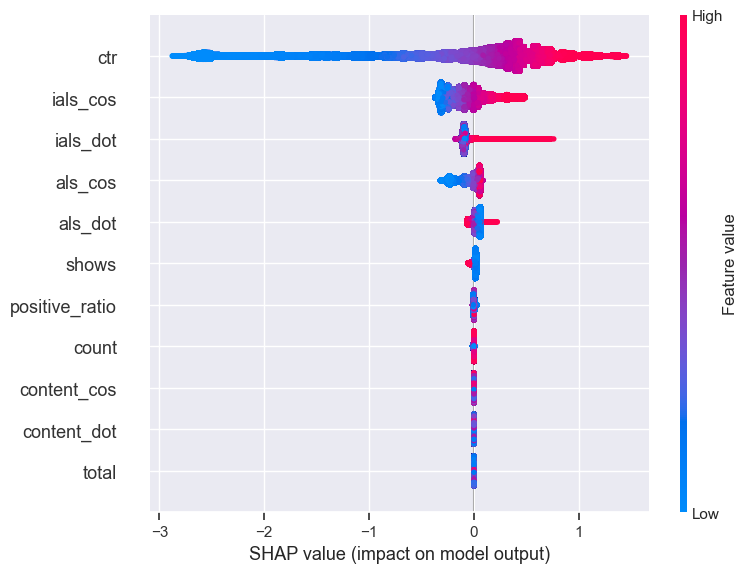

In [6]:
shap_test = shap.TreeExplainer(cb_ranking).shap_values(test_df_features)
shap.summary_plot(shap_test, test_df_features, auto_size_plot=True)

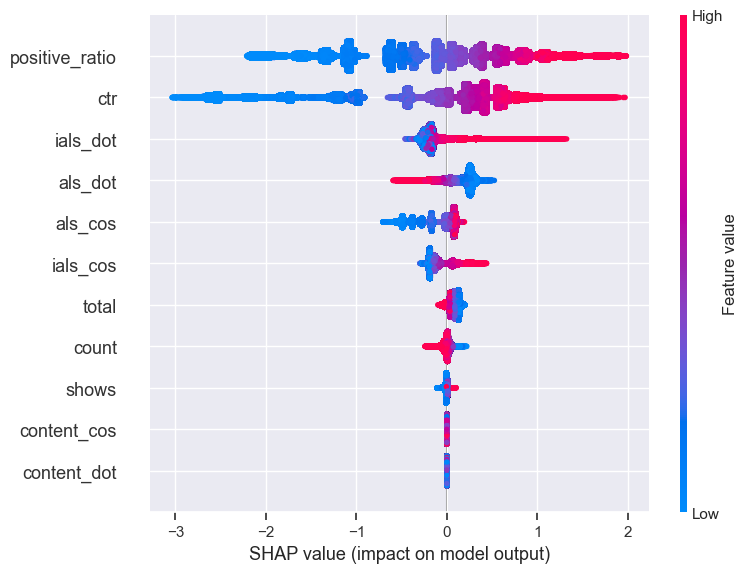

In [7]:
shap_test = shap.TreeExplainer(cb_classification).shap_values(test_df_features)
shap.summary_plot(shap_test, test_df_features, auto_size_plot=True)

In [11]:
cb_ranking.get_best_score()['validation']

{'NDCG:type=Base': 0.6310502305887867,
 'PrecisionAt:top=100': 0.17868374098669368,
 'MAP': 0.3341742385289046,
 'PairLogit:max_pairs=100': 0.5526906891341107,
 'AUC': 0.6973613010380174}

In [12]:
cb_classification.get_best_score()['validation']

{'Logloss': 0.3181432793204724,
 'NDCG:type=Base': 0.6316048144224438,
 'PrecisionAt:top=100': 0.1784261991608473,
 'MAP': 0.33445352971959164,
 'AUC': 0.782198519437322}

**Last metric (AUC) is not really relevant, added for curiocity**

**Combining statistical features and user-item iteraction embeddings plus content based embeddings is supposed to give a full representation of potential user-item interactions for model.\
In our case, metrics PrecisionAt100, MAP and NDCG turned out to be the quite the same for each of two models. Possible reason for this is that we had only two possible rating values (0 and 1) so classification works pretty well on this data.\
Also, by analysing shap values, we see, that content embeddings had 0 value on models. May be this is because of issues in their calculation, but I couldn't find it out.\
Definetely very important feature is CTR, wich has very big influence for both models.\
Overall, seems like, statistical features have more influence on classification model than on ranker, since for ranker all statistical features had nearly zero value except CTR.\
ALS embeddings stabily give good impact on model result, particulary iALS is better for ranking**